### Data Exploration

This file is just to play around with one of the batches to get a feel for it. I'll use the events stored in `batch_1_0.parquet` so that it's accessible to others.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load batch_1 train into a DataFrame
batch1 = pd.read_parquet('../batches_train/batch_1_repartitions/part.0.parquet')

In [5]:
batch1.head()

,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True


In [6]:
# returns 0th row
batch1.iloc[0]

sensor_id     3918
time          5928
charge       1.325
auxiliary     True
Name: 24, dtype: object

In [7]:
event_ids = list(set(batch1.index))

In [8]:
# loc is different; returns event_id matching 24
# So here are all pulses from event 24
# for event_id in event_ids:
#     print(batch1.loc[event_id].shape[0])
# Seems like event_ids[3] is a good length (120)
event_ids[3]

786452

In [9]:
sensor_geom = pd.read_csv('../sensor_geometry.csv')
sensor_geom

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


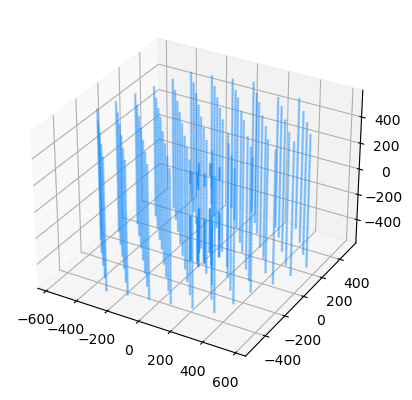

In [40]:
# Plot the sensors
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
           c='dodgerblue',
           s=1,
           alpha=0.4)

# ax.view_init(30,-115)

plt.show()

In [42]:
# Make a function that outputs (x,y,z) for a sensor_id input
def id_to_xyz(sen):
    row = tuple(sensor_geom.loc[sen][1:4])
    return row

In [43]:
# Plot event_id = 786452, we'll leave coloring for later 
event = batch1.loc[786452]

In [44]:
event

,sensor_id,time,charge,auxiliary
event_id,,,,
786452,2783,5905,1.625,True
786452,2783,5973,1.425,True
786452,1555,6277,1.225,True
786452,1555,6290,0.875,True
786452,2996,6519,0.775,True
...,...,...,...,...
786452,2180,22284,0.925,True
786452,2364,22309,0.925,True
786452,3302,22426,0.925,True


<IPython.core.display.Javascript object>


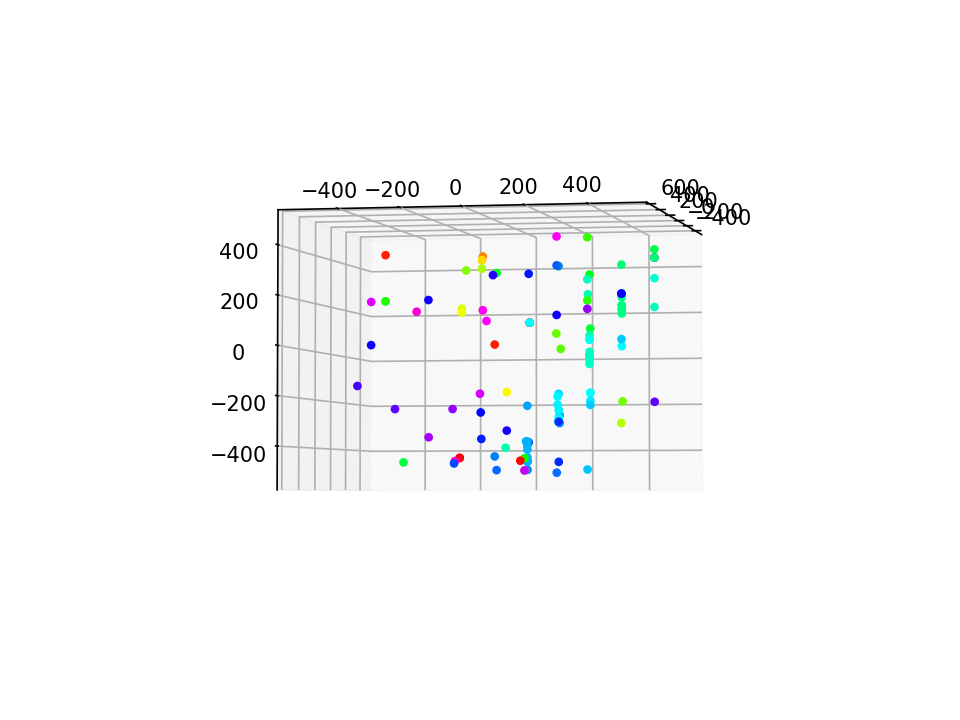

In [58]:
# Plot this event
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter([id_to_xyz(s)[0] for s in event.sensor_id],
           [id_to_xyz(s)[1] for s in event.sensor_id],
           [id_to_xyz(s)[2] for s in event.sensor_id],
           c=event.time,
           cmap='gist_rainbow',
           s=10,
           alpha=1)

plt.show()